Build feature and output arrays

In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder

# lists for all data
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

# load JSON-file
with open(f"data/WPPs+production+wind.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)[:10] # only use the first 10 wpps for now

# collect data
for wpp in WPP_production_wind:
    all_turbine_types.append(wpp["Turbine"])
    all_hub_heights.append(wpp["Hub_height"] if not pd.isna(wpp["Hub_height"]) else 100)
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append(wpp["Commission_date"] if wpp["Commission_date"] != "nan" else "2015/06")
    all_production_data.append(wpp["Production"])

# replace NaN-values in turbine types with unambiguous names
nan_counter = 1
for idx, turbine in enumerate(all_turbine_types):
    if pd.isna(turbine):
        all_turbine_types[idx] = f"nan{nan_counter}"
        nan_counter += 1

# One-Hot-Encoding for turbine types
encoder = OneHotEncoder(sparse_output=False)
turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

# correct data format for commissioning dates
all_commissioning_dates = [
    "2015/06" if date == "nan" else f"{date}/06" if isinstance(date, str) and "/" not in date else date
    for date in all_commissioning_dates
]

# convert to datetime
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# calculate age
current_date = pd.Timestamp("2024-12-01")
ages = current_date.year * 12 + current_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# create combined features and output lists
combined_features_raw = []
output_raw = []

# convert data in feature arrays
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # repetitions for common features
    turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])

    # extract production values and wind speeds
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1)
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    # combine all features
    combined_chunk = np.hstack((
        turbine_type_repeated,
        hub_height_repeated,
        capacity_repeated,
        age_repeated,
        wind_speeds
    ))

    # add the data
    combined_features_raw.append(combined_chunk)
    output_raw.append(production_values)

# combine all data chunks to one array
combined_features_raw = np.vstack(combined_features_raw)
output_raw = np.vstack(output_raw)

# tound all values to two decimal places
combined_features_raw = np.round(combined_features_raw, decimals=2)
output_raw = np.round(output_raw, decimals=2)

Scale feature vector and define Dataset

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch

combined_features = combined_features_raw.copy()
output = output_raw.copy()

# Standardisierung der numerischen Features (individuell!)
wind_scaler = StandardScaler()
combined_features[:, -1] = wind_scaler.fit_transform(combined_features[:, -1].reshape(-1, 1)).flatten() # scale wind speeds
scaler = StandardScaler()
combined_features[:, -2] = scaler.fit_transform(combined_features[:, -2].reshape(-1, 1)).flatten() # scale ages
combined_features[:, -3] = scaler.fit_transform(combined_features[:, -3].reshape(-1, 1)).flatten() # scale capacities
combined_features[:, -4] = scaler.fit_transform(combined_features[:, -4].reshape(-1, 1)).flatten() # scale hub heights

# Trainings- und Testaufteilung
train_features, test_features, train_targets, test_targets = train_test_split(combined_features, output, test_size=0.2, shuffle=True)

# Dataset-Klasse für PyTorch
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Erstellung der PyTorch-Datasets
train_val_dataset = WindPowerDataset(train_features, train_targets)
test_dataset = WindPowerDataset(test_features, test_targets)

# Ausgabe der Formen
print("Train and Validation Features Shape:", train_features.shape)
print("Train and Validation Targets Shape:", train_targets.shape)
print("Test Features Shape:", test_features.shape)
print("Test Targets Shape:", test_targets.shape)

Train and Validation Features Shape: (357969, 13)
Train and Validation Targets Shape: (357969, 1)
Test Features Shape: (89493, 13)
Test Targets Shape: (89493, 1)


Define Model

In [4]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)  # No activation in the output layer for regression
        return x

Hyperparameter search: Training, Validation

In [10]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import shutil
import os
import subprocess
from torch.utils.tensorboard import SummaryWriter

# Hyperparameter-Raum definieren
# param_space = {
#     "hidden_size": [32, 64, 128, 256],
#     "batch_size": [16, 32, 64],
#     "lr": [1e-2, 1e-3, 1e-4],
#     "number_epochs": [20, 50, 100],
# }
param_space = {
    "hidden_size": [32],
    "batch_size": [32],
    "lr": [1e-3],
    "number_epochs": [20],
    "n_splits": [2]
}

# Funktion zur Auswahl eines zufälligen Parametersets
def random_search(param_space, n_trials):
    trials = []
    for _ in range(n_trials):
        trial = {key: random.choice(values) for key, values in param_space.items()}
        trials.append(trial)
    return trials

# Generiere zufällige Parameterkombinationen
n_trials = 1
params = random_search(param_space, n_trials)[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# KFold-Objekt
kf = KFold(n_splits=params["n_splits"], shuffle=True, random_state=42)
len_train_val_dataset = len(train_val_dataset)

# Ergebnis-Tracking
best_val_loss = float("inf")
best_params = None
results = []

input_size = train_features.shape[1]

# TensorBoard-Prozess beenden
try:
    subprocess.run(["taskkill", "/IM", "tensorboard.exe", "/F"], check=True)
    print("Terminated TensorBoard process")
except subprocess.CalledProcessError:
    print("No TensorBoard process found or could not be terminated")

log_dir = "runs"

# Löschen, wenn der Ordner existiert
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

# TensorBoard neu starten
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

subprocess.Popen(["tensorboard", "--logdir=runs", "--bind_all"])
print("TensorBoard started.")

avg_val_loss = 0.0  # average validation loss over all folds

for fold, (train_idx, val_idx) in enumerate(kf.split(range(len_train_val_dataset)), 1):

    print(f"  Fold {fold}/{kf.n_splits}")
    writer = SummaryWriter(f"{log_dir}/fold_{fold}")

    # model
    example_input = torch.randn(params["batch_size"], input_size).to(device)
    model = MLP(input_size=input_size, hidden_size=params["hidden_size"], output_size=1).to(device)

    # visualisation of model architecture
    writer.add_graph(model, example_input)

    train_fold_dataset = Subset(train_val_dataset, train_idx)
    val_fold_dataset = Subset(train_val_dataset, val_idx)

    train_loader = DataLoader(train_fold_dataset, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_fold_dataset, batch_size=params["batch_size"], shuffle=True)

    # loss and optimiser
    criterion = nn.HuberLoss()
    MAE_error = torch.nn.L1Loss()
    MSE_error = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    # training
    for epoch in range(params["number_epochs"]):
        print(f"    Epoch {epoch+1}/{params['number_epochs']}")
        model.train()
        training_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            training_loss += loss.item()

            optimizer.zero_grad()  # Gradienten zurücksetzen
            loss.backward()        # Gradienten berechnen
            optimizer.step()       # Parameter aktualisieren

        # protocol training loss
        writer.add_scalar("Training Loss", training_loss / len(train_loader), epoch)

        print(f"    Fold Training Loss: {training_loss / len(train_loader):.4f}")

        # validation
        model.eval()
        fold_val_loss = 0.0
        MAE_loss = 0.0
        MSE_loss = 0.0

        # for late visualisation
        batch_x_all = []
        batch_y_all = []
        val_outputs_all = []
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:

                batch_x_all.append(batch_x.detach().cpu().numpy())
                batch_y_all.append(batch_y.detach().cpu().numpy())

                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                val_outputs = model(batch_x)

                val_outputs_all.append(val_outputs.detach().cpu().numpy())

                fold_val_loss += criterion(val_outputs, batch_y).item()
                MAE_loss += MAE_error(val_outputs, batch_y).item()
                MSE_loss += MSE_error(val_outputs, batch_y).item()
        
        batch_x_all = np.concatenate(batch_x_all)
        batch_y_all = np.concatenate(batch_y_all)
        val_outputs_all = np.concatenate(val_outputs_all)

        fold_val_loss /= len(val_loader)
        MAE_loss /= len(val_loader)
        MSE_loss /= len(val_loader)
        writer.add_scalar("Validation Loss", fold_val_loss, epoch)
        print(f"    Fold Validation Loss (Huber loss): {fold_val_loss:.4f}, MAE: {MAE_loss:.4f}, MSE: {MSE_loss:.4f}")
        avg_val_loss += fold_val_loss

    # TensorBoard schließen
    writer.close()

avg_val_loss /= kf.n_splits
print(f"  Trial Average Validation Loss: {avg_val_loss:.4f}")

# Ergebnisse speichern
results.append({"params": params, "avg_val_loss": avg_val_loss})

# Bestes Ergebnis aktualisieren
if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    best_params = params

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

Terminated TensorBoard process
TensorBoard started.
  Fold 1/2
    Epoch 1/20
    Fold Training Loss: 18.9195
    Fold Validation Loss (Huber loss): 24.2590, MAE: 24.7407, MSE: 2023.1995
    Epoch 2/20
    Fold Training Loss: 17.7376
    Fold Validation Loss (Huber loss): 21.1089, MAE: 21.5895, MSE: 1728.4094
    Epoch 3/20
    Fold Training Loss: 17.4258
    Fold Validation Loss (Huber loss): 20.2825, MAE: 20.7605, MSE: 1937.9518
    Epoch 4/20


KeyboardInterrupt: 

<h1>Visualisation of validation results

C:\Users\alexa\AppData\Local\Temp\ipykernel_41796\2295863842.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', 2*len(unique_turbine_types))
c:\Users\alexa\anaconda3\envs\webapp_env_conda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


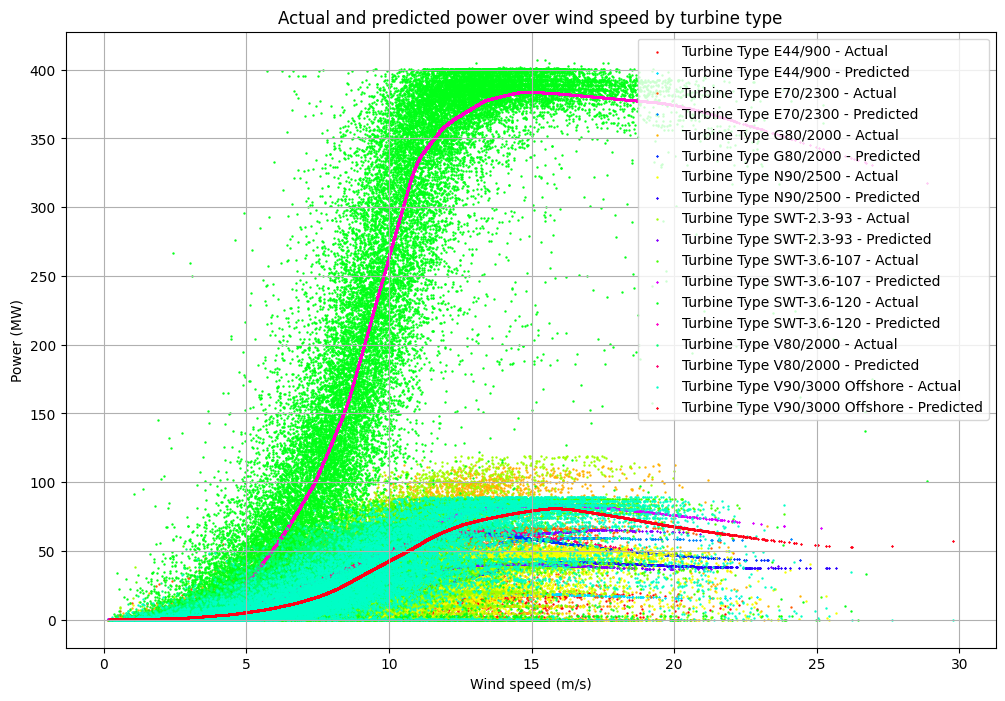

In [59]:
# reconstruct original wind speeds
wind_speeds_validation = wind_scaler.inverse_transform(batch_x_all[:, -1].reshape(-1, 1)).flatten()

# reconstruct original turbine types
turbine_types_validation = np.argmax(batch_x_all[:, 0:-4], axis=1)
turbine_types_validation = encoder.categories_[0][turbine_types_validation]

# Erstellen eines Farbschemas für verschiedene Turbinentypen
unique_turbine_types = np.unique(turbine_types_validation)
colors = plt.cm.get_cmap('hsv', 2*len(unique_turbine_types))

# Erstellen des Scatterplots mit verschiedenen Farben für Turbinentypen
plt.figure(figsize=(12, 8))

# Für jeden Turbinentyp einen Scatter-Plot mit einer anderen Farbe
for i, turbine_type in enumerate(unique_turbine_types):
    mask = turbine_types_validation == turbine_type  # Maske für den jeweiligen Turbinentyp
    plt.scatter(wind_speeds_validation[mask], batch_y_all[mask], s=0.5, color=colors(i), label=f"Turbine Type {turbine_type} - Actual")
    plt.scatter(wind_speeds_validation[mask], val_outputs_all[mask], s=0.5, color=colors(len(unique_turbine_types)+i), marker='x', label=f"Turbine Type {turbine_type} - Predicted")

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted power over wind speed by turbine type')
plt.legend()
plt.grid(True)
plt.show()

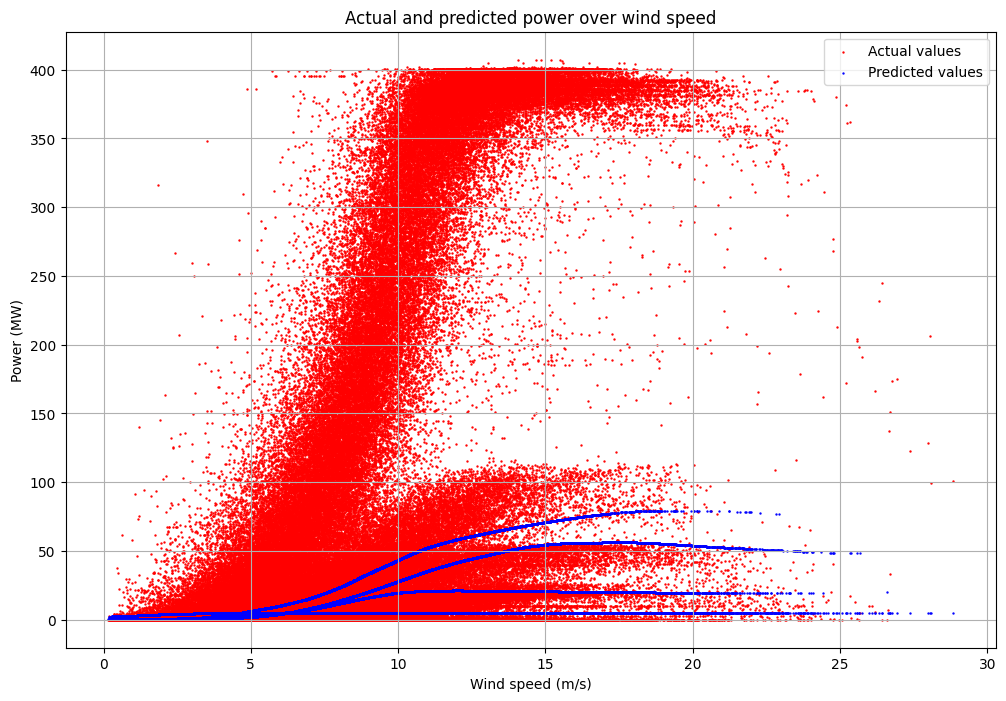

C:\Users\alexa\AppData\Local\Temp\ipykernel_41796\1354011826.py:21: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(wind_speeds_validation, (val_outputs_all-batch_y_all) / batch_y_all, color='blue', s=0.5)


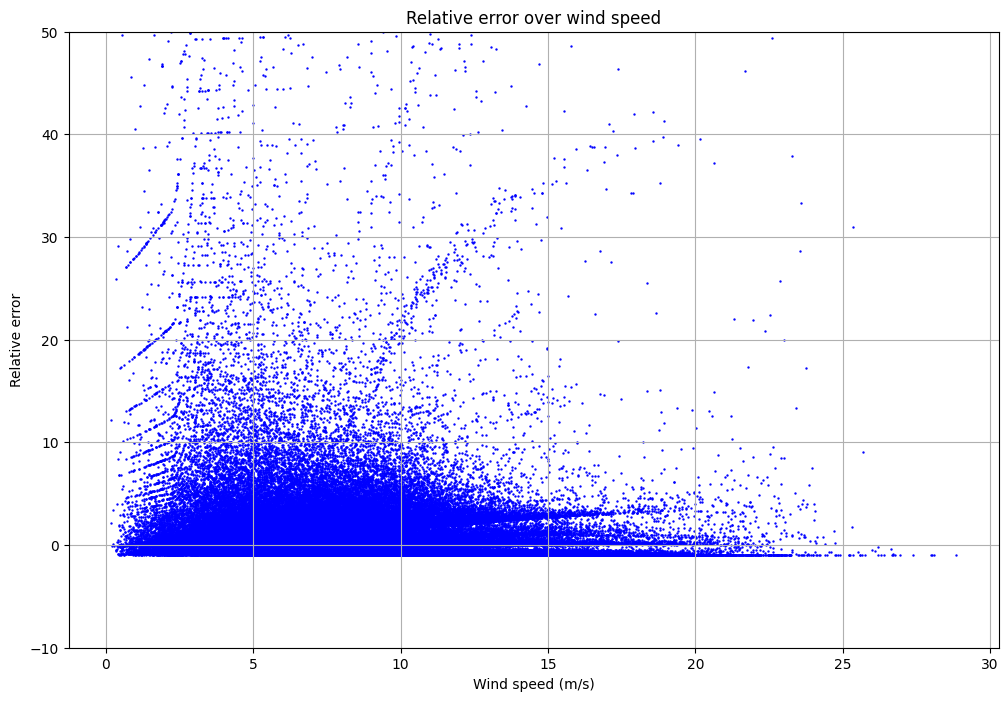

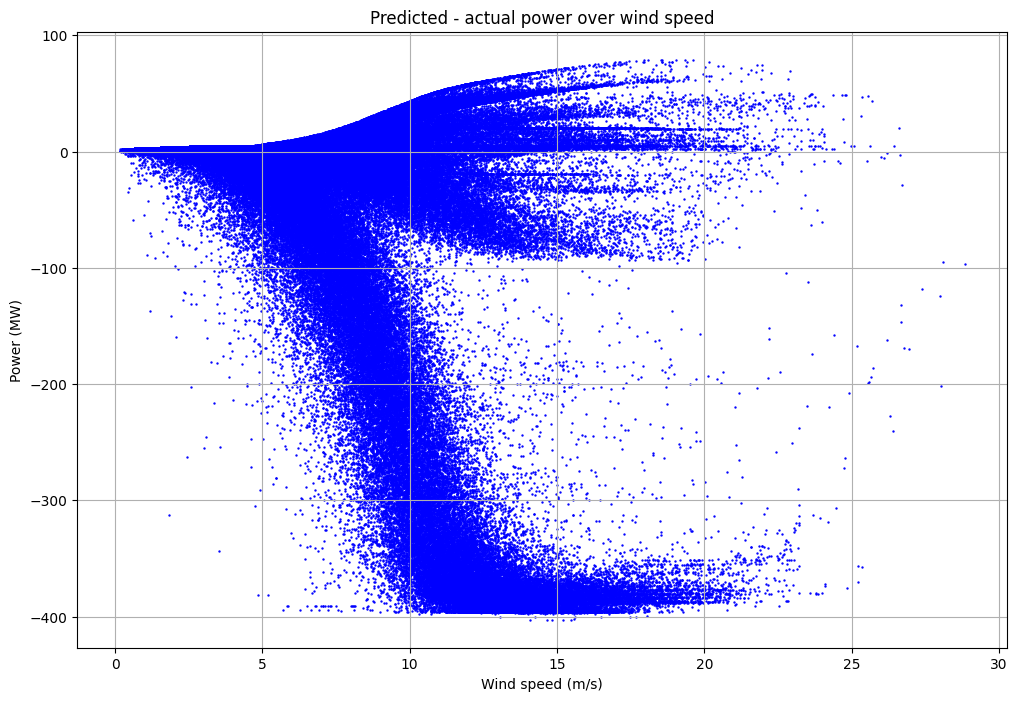

last ten validation values:
         wind speed  actual values  predicted values
0             6.62           1.69         13.433886
1             5.74           1.63          9.130919
2             4.68           1.28          5.015311
3             4.19           0.72          3.563222
4             3.62           0.68          2.243630
...            ...            ...               ...
178980        6.42           1.70          5.748619
178981        5.83           1.28          3.741520
178982        5.60           1.96          3.180400
178983        5.60           3.74          3.180400
178984        6.37           0.31          5.552657

[178985 rows x 3 columns]


In [64]:
import matplotlib.pyplot as plt

# reconstruct original wind speeds
wind_speeds_validation = wind_scaler.inverse_transform(batch_x_all[:, -1].reshape(-1, 1)).flatten()

# reconstruct original turbine types
turbine_types_validation = np.argmax(batch_x_all[:, 0:-4], axis=1)
turbine_types_validation = encoder.categories_[0][turbine_types_validation]

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_validation, batch_y_all, s=0.5, color='red', label="Actual values")
plt.scatter(wind_speeds_validation, val_outputs_all, s=0.5, color='blue', label="Predicted values")
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted power over wind speed')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_validation, (val_outputs_all-batch_y_all) / batch_y_all, color='blue', s=0.5)
plt.ylim(-10, 50)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Relative error')
plt.title('Relative error over wind speed')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(wind_speeds_validation, val_outputs_all-batch_y_all, color='blue', s=0.5)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Predicted - actual power over wind speed')
plt.grid(True)
plt.show()

# Tabelle erstellen und anzeigen
results_df = pd.DataFrame({
    "wind speed": wind_speeds_validation,
    "actual values": batch_y_all.flatten(),
    "predicted values": val_outputs_all.flatten()
})
print("last ten validation values:\n", results_df)

Histograms showing error distribution

In [35]:
import numpy as np

# Fehlerberechnung
absolute_errors = val_outputs_all - batch_y_all
relative_errors = (val_outputs_all - batch_y_all) / (batch_y_all + 1e-8)

# Berechnung von Mittelwert und Standardabweichung
mean_abs_error = np.mean(absolute_errors)
std_abs_error = np.std(absolute_errors)

mean_rel_error = np.mean(relative_errors)
std_rel_error = np.std(relative_errors)

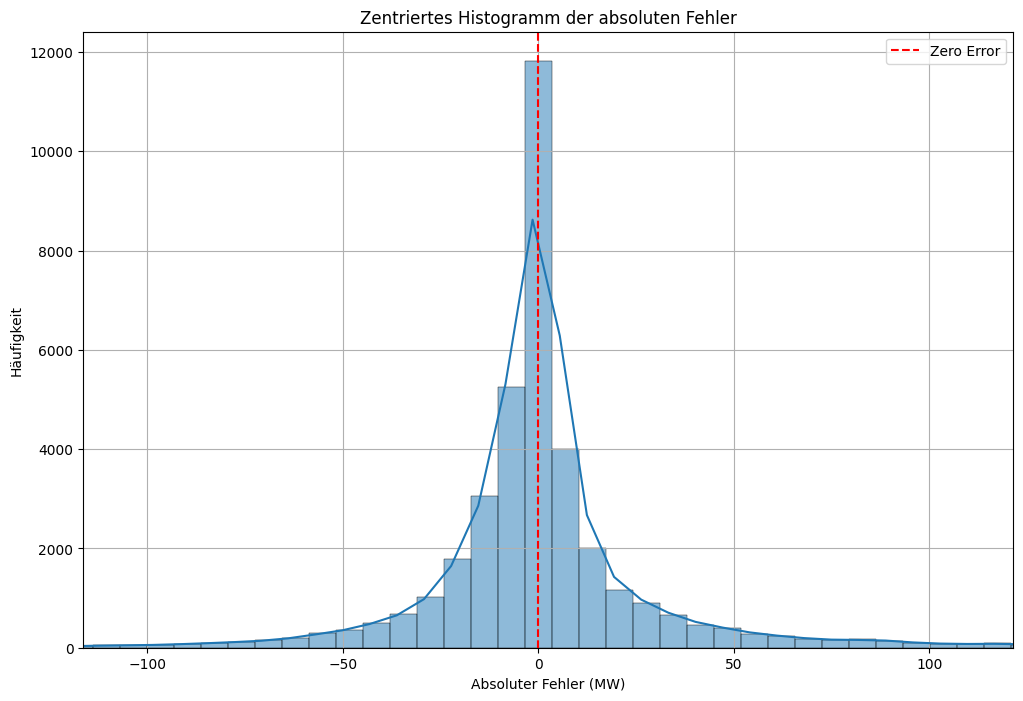

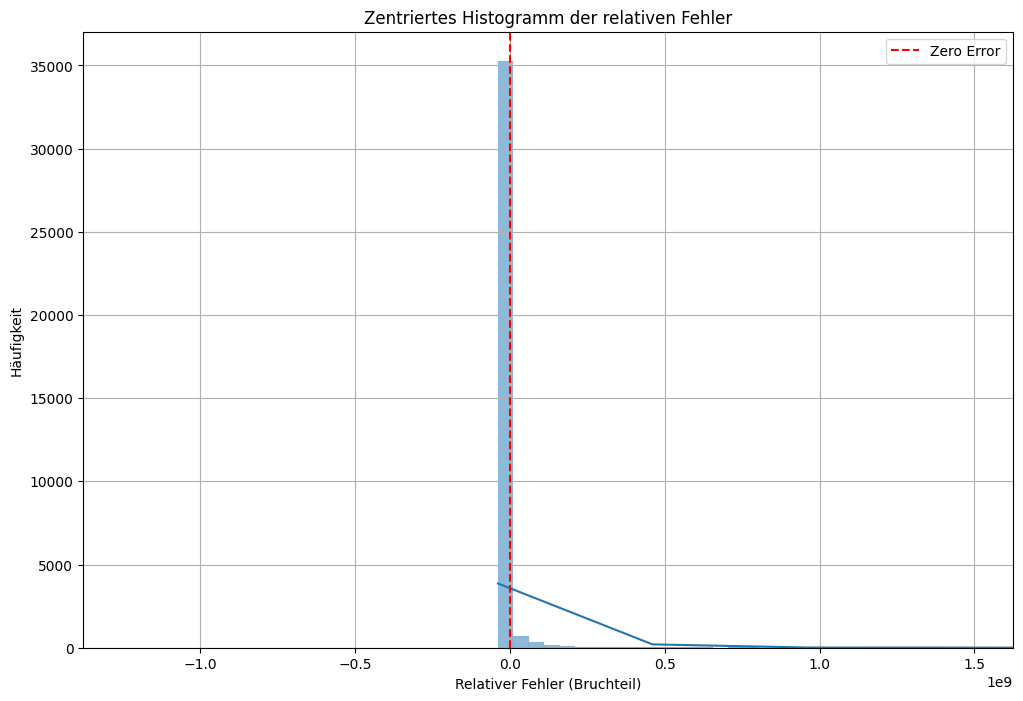

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Absoluter Fehler: Histogramm um 0 zentrieren
plt.figure(figsize=(12, 8))
sns.histplot(absolute_errors, bins=200, kde=True, color='skyblue')
plt.xlim(mean_abs_error - 3*std_abs_error, mean_abs_error + 3*std_abs_error)
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Zentriertes Histogramm der absoluten Fehler")
plt.xlabel("Absoluter Fehler (MW)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

# Relativer Fehler: Histogramm um 0 zentrieren
plt.figure(figsize=(12, 8))
sns.histplot(relative_errors, bins=2000, kde=True, color='orange')
plt.xlim(mean_rel_error - std_rel_error, mean_rel_error + std_rel_error)
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Zentriertes Histogramm der relativen Fehler")
plt.xlabel("Relativer Fehler (Bruchteil)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()


With best hyperparameters: Training and Testing

In [ ]:

# Test mit besten Parametern
example_input = torch.randn(best_params["batch_size"], input_size).to(device)
model = torch.jit.trace(
    MLP(input_size=input_size, hidden_size=best_params["hidden_size"], output_size=1).to(device), example_input
)
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

train_loader = DataLoader(train_val_dataset, batch_size=best_params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=True)

# Training mit besten Parametern
for epoch in range(best_params["number_epochs"]):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Test mit Testdaten
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        test_outputs = model(batch_x)
        test_loss += criterion(test_outputs, batch_y).item()

test_loss /= len(test_loader)
print(f"\nTest Loss: {test_loss:.4f}")

# Modell speichern
torch.save(model.state_dict(), "mlp_wind_power_model_best.pth")

<h1>Evaluate Feature Importance

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feature-Namen definieren
feature_names = np.array((
    list(encoder.get_feature_names_out(["Turbine"])) + 
    ["Hub_height", "Capacity", "Age", "Wind_speed"]
))

shap

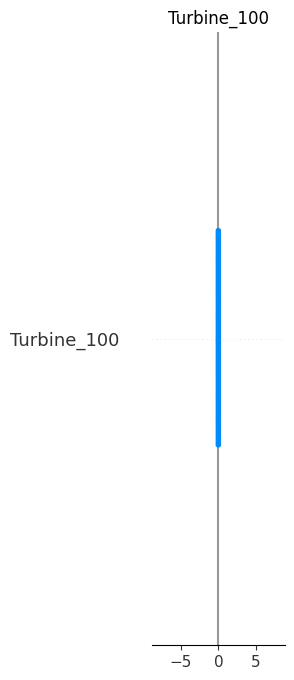

In [ ]:
import shap

# Eingabegröße korrigieren
input_tensor = torch.tensor(combined_features_subset[:100], dtype=torch.float32).to(device)

# SHAP-Explainer erstellen
explainer = shap.GradientExplainer(model, input_tensor)

# SHAP-Werte berechnen
shap_values = explainer.shap_values(input_tensor)

# Visualisierung
shap.summary_plot(
    shap_values, combined_features_subset[:100], feature_names=feature_names
)


gradient

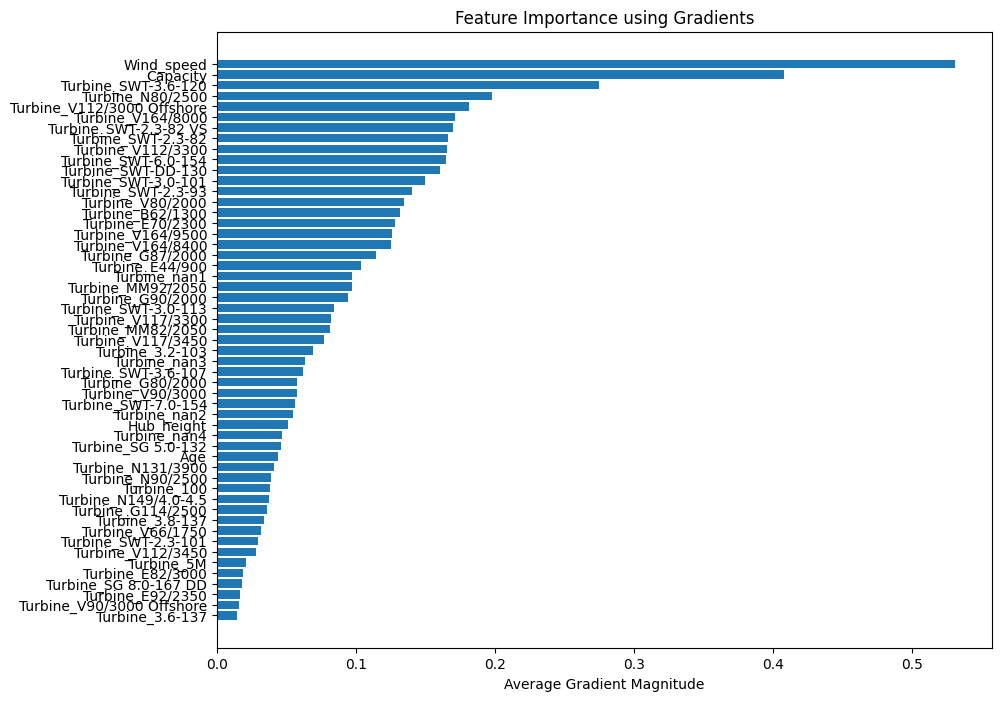

In [ ]:
# Modell in Evaluierungsmodus
model.eval()

# Eingabegröße reduzieren
inputs = torch.tensor(combined_features[:100], dtype=torch.float32, requires_grad=True).to(device)

# Vorhersage berechnen
outputs = model(inputs)

# Mittleren Output für den Gradienten berechnen
outputs.mean().backward()

# Gradienten extrahieren und sortieren
feature_importance = inputs.grad.abs().mean(dim=0).cpu().detach().numpy()

# Nach Wichtigkeit sortieren
sorted_idx = np.argsort(feature_importance)

# Visualisierung
plt.figure(figsize=(10, 8))
plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Average Gradient Magnitude")
plt.title("Feature Importance using Gradients")
plt.show()


Spearman Correlation Coefficient Matrix

In [66]:
import pandas as pd

num_turbine_type_columns = turbine_types_onehot.shape[1]

# DataFrame ohne Turbinentypen erstellen
df = pd.DataFrame(
    combined_features[:, num_turbine_type_columns:], 
    columns=["Hub Height", "Capacity", "Commissioning Date", "Wind Speed"]
)

# Ausgabe hinzufügen
df['Power'] = output.flatten()

# Spearman-Korrelation berechnen
spearman_corr_matrix = df.corr(method='spearman')

# Farbcodierte Tabelle anzeigen
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Spearman Correlation Heatmap")
plt.show()